In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate 
import pandas as pd

## 1. Fuction for interpolating polynomials

Write a function which 
- returns the value at $x$ 
- of the $n^{th}$ order interpolating polynomial

The interpolating polynomial is constructed from the vector $(x, y)$

In [3]:
def poly_Lagrange(X_base, Y_base, X):
    """
    This function takes the base point data and estimates the function at any given point(s) X
    """
    
    n = X_base.shape[0]
    m = np.array(X).shape[0]
    Y = np.array([])
    
    for j in range(m):
        PX = np.array([])
    
        for k in range(n):
            Lkn = np.array([])
            for i in range(n):
                if i != k:
                    Lkn_i = (X[j] - X_base[i])/(X_base[k] - X_base[i])
                    Lkn = np.append(Lkn, Lkn_i)
            Lkn = np.prod(Lkn, axis = 0)
            PXi = Y_base[k]*Lkn
            PX = np.append(PX, PXi)
            
        Y = np.append(Y, np.sum(PX,axis = 0))
    
    return Y

Test the code using the following vectors

In [4]:
#Vector 1
X_hw34 = np.array([1, -1, 3])
Y_hw34 = np.array([0, -3, -4])

#Vector 2
X_hw36 = np.array([1, -2, 0, 3, -1, 7])
Y_hw36 = np.array([-2, -56, -2, 4, -16, 376])

In [4]:
X_hw34_test = poly_Lagrange(X_hw34, Y_hw34, np.linspace(X_hw34.min(), X_hw34.max(), 1000))
X_hw36_test = poly_Lagrange(X_hw36, Y_hw36, np.linspace(X_hw36.min(), X_hw36.max(), 1000))

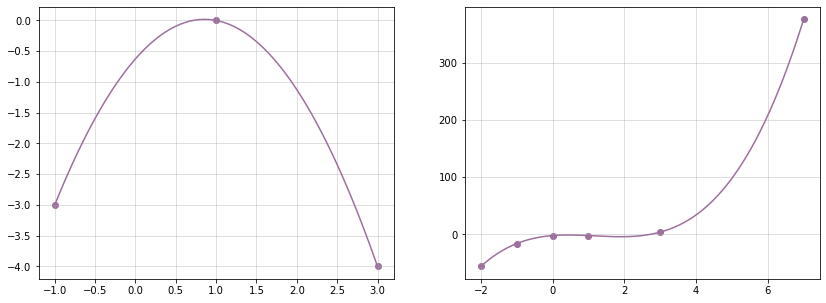

In [5]:
fig = plt.figure(figsize = (14, 5))

#Vector 1 result
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(np.linspace(X_hw34.min(), X_hw34.max(), X_hw34_test.shape[0]), X_hw34_test, color = '#9C6F9C')
ax1.scatter(X_hw34, Y_hw34, color = '#9C6F9C')
ax1.grid(True, alpha = 0.5)

#Vector 2 result
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(np.linspace(X_hw36.min(), X_hw36.max(), X_hw36_test.shape[0]), X_hw36_test, color = '#9C6F9C')
ax2.scatter(X_hw36, Y_hw36, color = '#9C6F9C')
ax2.grid(True, alpha = 0.5)

plt.show()

## Question 2

### Part 1:
Construct a _cubic spline_ and a _Lagrange polynomial_ by considering the case 

$(x_j, y_j) = (j, j)$ with $j = 1, ..., 10$

In [6]:
X_base2 = np.arange(1, 10.1)
Y_base2 = np.arange(1, 10.1)

#### (i) Constructing piecewise cubic polynomial

In [7]:
def coef_matrix(X, Y, print_f = True, get_matricesMV = False):
    """    
    Arguments:
    - X [numpy array] consisting of the basis points
    - Y [numpy array] consisting of points as a function of coressponding X
    - print_func [bool] whether to print the whole piece-wise cubic function
    
    Return:
    - coef [numpy array] a matrix of coefficients of X^0, X^1, X^2, X^3 piece-wise cubic polynomials 
    """
    
    #(I) Construct M
    #Reshape X, Y
    X = X.reshape(-1,)
    Y = Y.reshape(-1,)
    #Number of polynomials - n
    n = len(X) - 1
    M = np.array([])
    
    #By general interpolation requirement
    for i in range(n):
        zeros_head = np.zeros((4*i,))
        mi = 1
        zeros_tail = np.zeros((4*(n-i) - 1))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    
    dXn = X[-1] - X[-2]
    Mn = np.hstack([np.zeros((4*(n-1))),
                    1, dXn, dXn**2, dXn**3])
    M = np.append(M, Mn).reshape(-1, 4*n)
    
    #By continuity requirement
    for i in range(1, n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([1, dXi, dXi**2, dXi**3, -1, 0, 0, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #By smoothness requirement
    for i in range(1,n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([0, 1, 2*dXi, 3*dXi**2, 0, -1, 0, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #By curvature requirement
    for i in range(1,n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([0, 0, 1, 3*dXi, 0, 0, -1, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #Requirements for stable first derivative
    dX1 = X[1]-X[0]
    dXn = X[-1] - X[-2]
    M4n_2 = np.hstack([0, 0, 1, 3*dX1,
                       np.zeros(4*(n-1))])
    M4n_1 = np.hstack([np.zeros(4*(n-1)),
                       0, 0, 1, 3*dXn])
    M = np.append(M, [M4n_2, M4n_1]).reshape(-1, 4*n)
    
    #-------------------------------------
    #(II) Construct V
    V = np.hstack([Y,
                   np.zeros(4*n - (n+1))])
    
    #-------------------------------------
    #(III) Solve for parameters
    M_inv = np.linalg.inv(M)
    coef = np.dot(M_inv, V).reshape(-1, 4)
    
    if print_f:
        for i in range(n):
            print(f"P_{i}(X)\t=\t{coef[i, 0]:.2f}\t+{coef[i, 1]:.2f}*(X-{X[i]:.2f})\t+ {coef[i, 2]:.2f}(X-{X[i]:.2f})^2\t+ {coef[i, 3]:.2f}(X-{X[i]:.2f})^3\t for {X[i]:.2f} <= X < {X[i+1]:.2f}")
    if get_matricesMV:
        return coef, M, V
    
    return coef

In [9]:
def piecewise_cubic(X, X_base, coef_matrix):
    """
    Arguments:
    - X [array] consisting of points X to be interpolated
    - X_base [ascending sorted array] the base points used to construct the cubic polynomials
    - coef_matrix [np array] a matrix consisting of coefficients of piecewise polynomials
    Return:
    - Y [array] the interpolated values given X and the polynomial functions
    """
    
    n = len(X_base) - 1
    Y = np.array([])
    for x in X:
        for i in range(n):
            if ((x<X_base[i+1]) & (x >= X_base[i])):
                dx = x - X_base[i]
                A = coef_matrix[i]
                y = np.dot(A, np.hstack([1, dx, dx**2, dx**3]))
            elif x == X_base[-1]:
                dx = x - X_base[-2]
                y = np.dot(coef_matrix[-1], np.hstack([1, dx, dx**2, dx**3]) )
        Y = np.append(Y, y)
    return Y
            

In [10]:
print("The piecewise cubic spline constructed from the given base points is")
print()
coef_cubic_Q2 = coef_matrix(X = X_base2, Y = Y_base2)

The piecewise cubic spline constructed from the given base points is

P_0(X)	=	1.00	+1.00*(X-1.00)	+ 0.00(X-1.00)^2	+ -0.00(X-1.00)^3	 for 1.00 <= X < 2.00
P_1(X)	=	2.00	+1.00*(X-2.00)	+ 0.00(X-2.00)^2	+ -0.00(X-2.00)^3	 for 2.00 <= X < 3.00
P_2(X)	=	3.00	+1.00*(X-3.00)	+ -0.00(X-3.00)^2	+ 0.00(X-3.00)^3	 for 3.00 <= X < 4.00
P_3(X)	=	4.00	+1.00*(X-4.00)	+ 0.00(X-4.00)^2	+ -0.00(X-4.00)^3	 for 4.00 <= X < 5.00
P_4(X)	=	5.00	+1.00*(X-5.00)	+ -0.00(X-5.00)^2	+ 0.00(X-5.00)^3	 for 5.00 <= X < 6.00
P_5(X)	=	6.00	+1.00*(X-6.00)	+ 0.00(X-6.00)^2	+ -0.00(X-6.00)^3	 for 6.00 <= X < 7.00
P_6(X)	=	7.00	+1.00*(X-7.00)	+ 0.00(X-7.00)^2	+ -0.00(X-7.00)^3	 for 7.00 <= X < 8.00
P_7(X)	=	8.00	+1.00*(X-8.00)	+ -0.00(X-8.00)^2	+ 0.00(X-8.00)^3	 for 8.00 <= X < 9.00
P_8(X)	=	9.00	+1.00*(X-9.00)	+ 0.00(X-9.00)^2	+ -0.00(X-9.00)^3	 for 9.00 <= X < 10.00


#### (ii) Constructing cubic Lagrange polynomial

In [8]:
def poly_Lagrange_coef(X_base, Y_base, print_f = True):
    """
    Arguments: The base points
    - X_base [numpy array] of shape (n,)
    - Y_base [numpy array] of shape (n,)
    Return:
    - coef [numpy array] coefficients of Lagrange polynomial
    """
    
    n = X_base.shape[0]
    
    coef = np.array([]) 
    
    for k in range(n):
        Lkn = np.array([])
        for i in range(n):
            if i != k:
                Lkn = np.append(Lkn, 1/(X_base[k] - X_base[i]))
        #print(Lkn)
        #print(np.prod(Lkn, axis = 0))
        #print('-------')
        
        coef_i = Y_base[k]*np.prod(Lkn, axis = 0)
        coef = np.append(coef, coef_i)
    if print_f:
        print('P(X) =', end = '')
        for k in range(n):
            print(f'{coef[k]:.6f}', end = '')
            for i in range(n):
                if k != i:
                    print(f'(X - {X_base[i]})', end = ' ')
            if k != n-1:
                print('+')
    
    return coef

In [11]:
coef_Lagrange_Q2 = poly_Lagrange_coef(X_base2, Y_base2)

P(X) =-0.000003(X - 2.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 7.0) (X - 8.0) (X - 9.0) (X - 10.0) +
0.000050(X - 1.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 7.0) (X - 8.0) (X - 9.0) (X - 10.0) +
-0.000298(X - 1.0) (X - 2.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 7.0) (X - 8.0) (X - 9.0) (X - 10.0) +
0.000926(X - 1.0) (X - 2.0) (X - 3.0) (X - 5.0) (X - 6.0) (X - 7.0) (X - 8.0) (X - 9.0) (X - 10.0) +
-0.001736(X - 1.0) (X - 2.0) (X - 3.0) (X - 4.0) (X - 6.0) (X - 7.0) (X - 8.0) (X - 9.0) (X - 10.0) +
0.002083(X - 1.0) (X - 2.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 7.0) (X - 8.0) (X - 9.0) (X - 10.0) +
-0.001620(X - 1.0) (X - 2.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 8.0) (X - 9.0) (X - 10.0) +
0.000794(X - 1.0) (X - 2.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 7.0) (X - 9.0) (X - 10.0) +
-0.000223(X - 1.0) (X - 2.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 7.0) (X - 8.0) (X - 10.0) +
0.000028(X - 1.0) (X - 2.0) (X - 3.0) (X - 4.0) (X - 5.0) (X - 6.0) (X - 7.0) (X

### Part 2:

Suppose there is an error in the data so that $y_5 = 5 + \epsilon $

In [12]:
e = 0.1
Y_base2[5-1] = Y_base2[5-1] + e 

In [13]:
eps = np.array([0.1, 0.05, 0.5, 0.9]) #0.1 as in the question, the other 3 are randomly chosen

N = 100
X_est2 = np.linspace(1, 10, N)

Y_base2_werror = np.array([])
Y_est_cubic2 = np.array([])
Y_est_Lr2 = np.array([])

for i in range(4):
    Y_basei = np.hstack([np.arange(1, 5),
                         5 + eps[i],
                         np.arange(6, 11)])
    Y_base2_werror = np.append(Y_base2_werror, Y_basei).reshape(-1, 10) 
    coef_cubici = coef_matrix(X_base2, Y_basei, print_f = False)
    
    #Piecewise Cubic Spline
    Y_est_cubici = piecewise_cubic(X_est2, X_base2, coef_cubici)
    Y_est_cubic2 = np.append(Y_est_cubic2, Y_est_cubici).reshape(-1, N)
    
    #Lagrange
    Y_est_Lri = poly_Lagrange(X_base2, Y_basei, X_est2)
    Y_est_Lr2 = np.append(Y_est_Lr2, Y_est_Lri).reshape(-1, N)

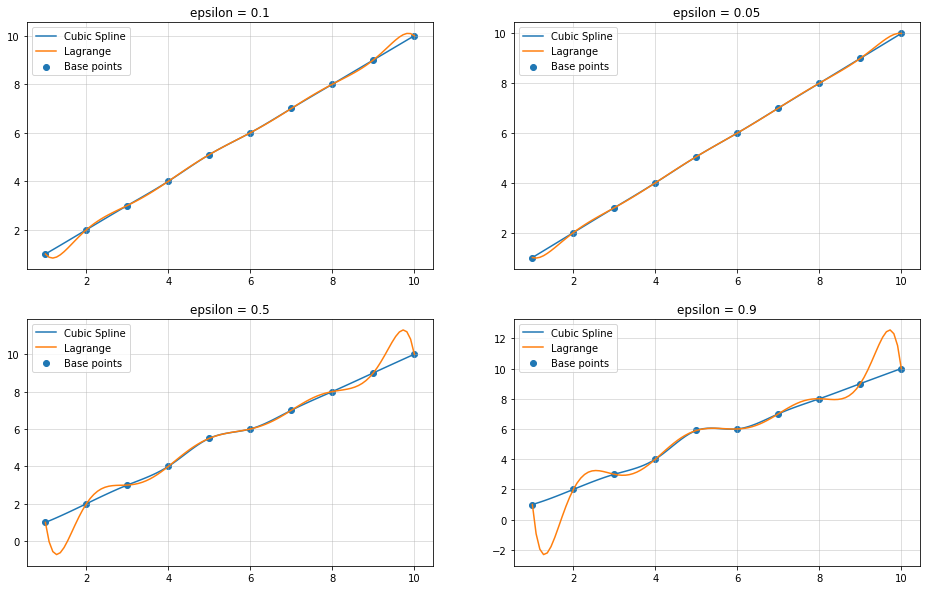

In [14]:
fig = plt.figure(figsize = (16, 10))

for i in range(4):
    axi = fig.add_subplot(2, 2, i+1)
    
    axi.set_title(f'epsilon = {eps[i]}')
    
    axi.scatter(X_base2, Y_base2_werror[i], label = 'Base points')
    axi.plot(X_est2, Y_est_cubic2[i], label = 'Cubic Spline')
    axi.plot(X_est2, Y_est_Lr2[i], label = 'Lagrange')
    axi.grid(True, alpha = 0.5)
    axi.legend()

__Comments__

- The Lagrange polynomial appears to be more curvy than the piecewise cubic spline, and more so toward the ends
- The higher the error $\epsilon$, the higher curvier the Lagrange plot; in other words, the Lagrange polynomial shows more oscillation toward the 2 ends of the interval in consideration

## Question 5

Let $[a, b] = [-5, 5]$ and $f(x) = \frac{1}{1+x^2}$. 

Using base points $x_i = a + \frac{(b-a)i}{n}$ for $i = 0, ..., n$ for each $n = 5, 10, 20, 50$

Plot on the same axis over the interval $[a, b]$ the function $f(x), P(x)$, and the error function $\epsilon(x)$

In [15]:
a, b = [-5,5]
n = np.array([5, 10, 20, 50])

In [16]:
def f(x):
    return 1/(1+x**2)

In [17]:
N = 500
X = np.linspace(a, b, N)
X.shape

(500,)

In [18]:
def plot_and_error(n_base, f, interval = [-5, 5], N = 1000):
    
    a, b = interval
    
    #(1) Generate base points
    X_base = np.array(a + (b-a)*np.arange(0, n_base+1)*1/n_base)
    Y_base = f(X_base)
    
    X = np.linspace(a, b, N)
    
    #(2) Estimate f(X) by Lagrange polynomial 
    PX = poly_Lagrange(X_base, Y_base, X)
    
    Error = np.abs(f(X) - PX)
    
    return X_base, Y_base, f(X), PX, Error

In [19]:
results = np.array([], dtype = 'object')
for i in range(n.shape[0]):
    ni = {}
    
    ni['X_base'], ni['Y_base'], ni['fX'], ni['PX'], ni['Error'] = plot_and_error(n[i], f, N = N)
    
    results = np.append(results, ni)
    

### Plotting

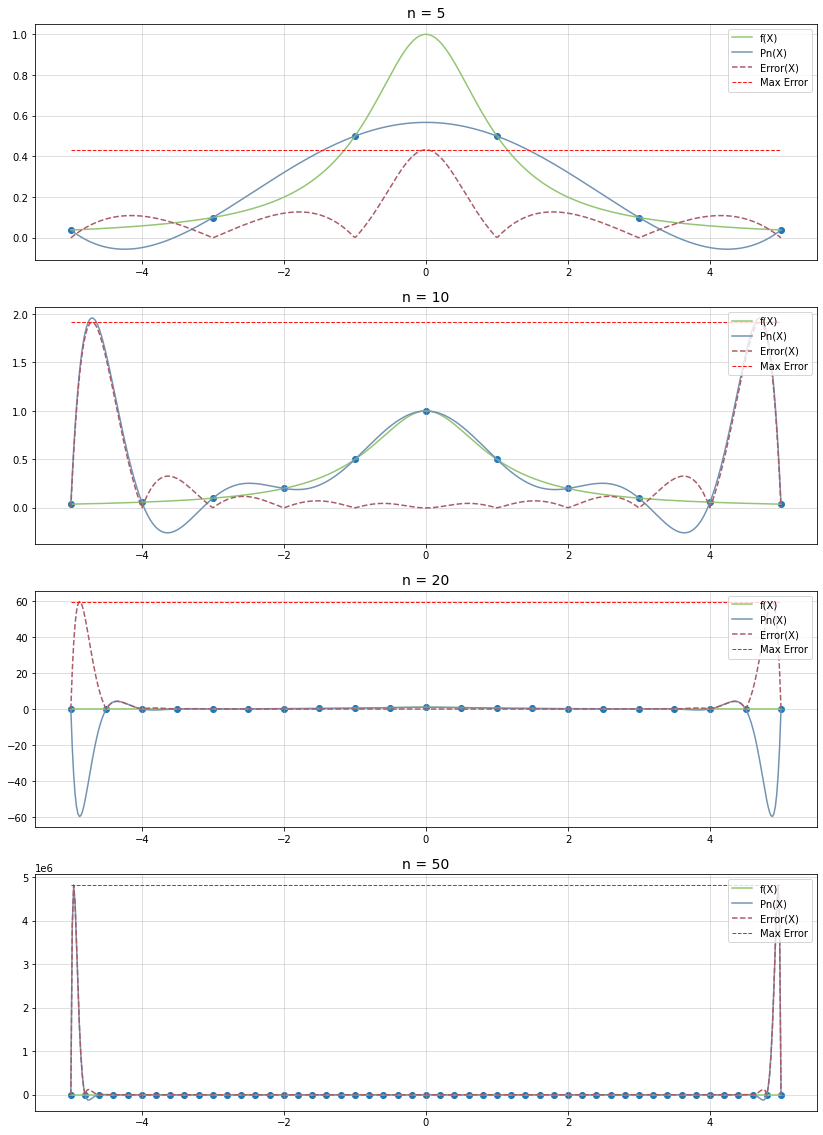

In [20]:
row = results.shape[0]
col = 1

w = col*14
l = row*5

fig = plt.figure(figsize = (w,l))

for i in range(results.shape[0]):
    axi = fig.add_subplot(row, col, i+1)
    axi.set_title(f'n = {n[i]}', size = 14)
    
    axi.plot(X, results[i]['fX'], color = '#93C572', label = 'f(X)')
    axi.plot(X, results[i]['PX'], color = '#7393B3', label = 'Pn(X)')
    axi.plot(X, results[i]['Error'], color = '#A95C68', label = 'Error(X)', linestyle = '--')
    axi.scatter(results[i]['X_base'], 
                results[i]['Y_base'])
    axi.plot(X, np.full((X.shape), results[i]['Error'].max()), 
             linestyle = '--', lw = 1, color = '#FB1616', label = 'Max Error' )

    axi.grid(True, alpha = 0.5)
    axi.legend(loc = 'upper right')

In [21]:
Error_max = np.array([])
Error_max_atX = np.array([])

for i in range(n.shape[0]):
    Error_max = np.append(Error_max, results[i]['Error'].max())
    max_at = X[np.where(results[i]['Error'].max())[0][0]]
    Error_max_atX = np.append(Error_max_atX, max_at)
    

In [22]:
Error_max_atX

array([-5., -5., -5., -5.])

In [23]:
Error_df = pd.DataFrame({'Maximum Error': Error_max,
                         'X': Error_max_atX}, 
                       index = np.arange(4))
Error_df

,Maximum Error,X
0,4.325989e-01,-5.0
1,1.915621e+00,-5.0
2,5.977105e+01,-5.0
3,4.817981e+06,-5.0


## Question 6

Use the Chebyshev base points, defined by

$x_i = \frac{a+b}{2} + \frac{b-a}{2}cos\frac{(2i+1)\pi}{2(n+1)}$ for $i = 0, ..., n$ for each $n = 5, 10, 20, 50$

In [24]:
def plot_and_error_Chebyshev(n_base, f, interval = [-5, 5], N = 1000):
    
    a, b = interval
    
    #(1) Generate base points
    i = np.arange(n_base+1)
    X_base = np.array((a+b)/2 + ((b-a)/2) * np.cos((2*i + 1)*np.pi / (2*(n_base+1))))
    Y_base = f(X_base)
    
    X = np.linspace(a, b, N)
    
    #(2) Estimate f(X) by Lagrange polynomial 
    PX = poly_Lagrange(X_base, Y_base, X)
    
    Error = np.abs(f(X) - PX)
    
    return X_base, Y_base, f(X), PX, Error

In [25]:
results2 = np.array([], dtype = 'object')
for i in range(n.shape[0]):
    ni = {}
    
    ni['X_base'], ni['Y_base'], ni['fX'], ni['PX'], ni['Error'] = plot_and_error_Chebyshev(n[i], f, [a,b], N = N)
    
    results2 = np.append(results2, ni)
    

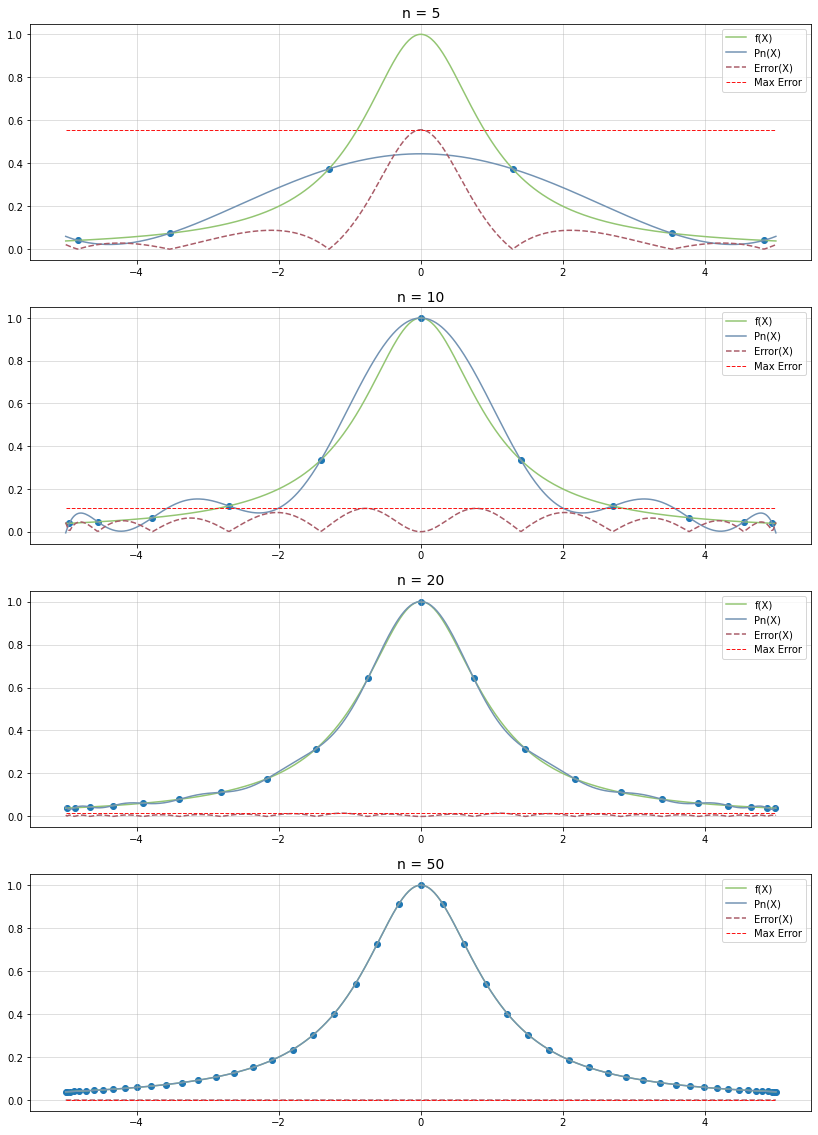

In [26]:
row = results.shape[0]
col = 1

w = col*14
l = row*5

fig = plt.figure(figsize = (w,l))

for i in range(results.shape[0]):
    axi = fig.add_subplot(row, col, i+1)
    axi.set_title(f'n = {n[i]}', size = 14)
    
    axi.plot(X, results2[i]['fX'], color = '#93C572', label = 'f(X)')
    axi.plot(X, results2[i]['PX'], color = '#7393B3', label = 'Pn(X)')
    axi.plot(X, results2[i]['Error'], color = '#A95C68', label = 'Error(X)', linestyle = '--')
    axi.scatter(results2[i]['X_base'], 
                results2[i]['Y_base'])
    axi.plot(X, np.full((X.shape), results2[i]['Error'].max()), 
             linestyle = '--', lw = 1, color = '#FB1616', label = 'Max Error' )

    axi.grid(True, alpha = 0.5)
    axi.legend(loc = 'upper right')

__Comments__

On the graphs of Question 5
- The polynomials of all cases of n pass through base points generated by the given $f(X)$, and thus the error functions equal 0 at base points
- However, except for the case of $n = 5$, the errors appear to be higher to the 2 ends of the interval.
- The possible reason is that a polynomial constructed fron $(n+1)$ base points can have at least $(n+1)$ distinct zeros, and thus at least $n$ local maxima/minima. Oscillation is expected in such polynomnials
- The maximum values of error could be very high (as in the last case of $n=50$

On the graphs of Question 6
- The polynomials all of cases on n pass through the base points, and thus the error functions equal 0 at base points
- The error functions appear to flatten out to the 2 ends of the intervals and vary closely to 0
- The maximum values of error get closer to 0 as the number of base points increases

## Question 7

### (a)

In [27]:
def quadratic_coef_matrix(X, f, print_func = True, get_matricesMV = False):
    """    
    Arguments:
    - X [numpy array] consisting of the basis points
    - f [function] actual function f(X)
    - print_func [bool] whether to print the whole piece-wise cubic function
    
    Return:
    - coef [numpy array] a matrix of coefficients of X^0, X^1, X^2 piece-wise quadratic polynomials 
    """
    
    #(I) Construct M
    X = X.reshape(-1,)
    Y = f(X).reshape(-1,)
    #Number of polynomials - n
    n = len(X) - 1
    
    M = np.array([])
    
    #By Qi(X_i-1) = f(X_i-1)
    M0 = np.hstack([[1, (X[0]-X[1]), ((X[0]-X[1])**2)],
                    np.zeros((3*n - 3))]).reshape(-1, 3*n)
    M = np.append(M, M0).reshape(-1, 3*n)
    
    #By Qi(X_i) = f(X_i)
    for i in range(1, n+1):
        zeros_head = np.zeros((3*(i-1),))
        mi = np.array([1, 0, 0])
        zeros_tail = np.zeros((3*(n-(i-1) - 1)))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 3*n)
    
    
    #By Qi(X_i) = f(X_i)
    for i in range(1, n+1):
        zeros_head = np.zeros((3*(i-1),))
        dX = X[i] - X[i-1]
        mi = np.array([1, dX/2, (dX/2)**2])
        zeros_tail = np.zeros((3*n-3*(i-1) - 3,))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 3*n)
    
    #By smoothness
    for i in range(1, n):
        zeros_head = np.zeros((3*(i-1),))
        dX = X[i] - X[i-1]
        mi = np.array([0, 1, 0, 0, -1, 2*dX])
        zeros_tail = np.zeros((3*n-3*(i-1) - 6,))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 3*n)
        
    # f(X') - midpoints
    Y_midpoints = np.array([])
    for i in range(1, n+1):
        Xmid = 1/2*(X[i] - X[i-1])
        Ymid = f(Xmid)
        Y_midpoints = np.append(Y_midpoints, Ymid).reshape(-1,)
    
    #-------------------------------------
    #(II) Construct V
    V = np.hstack([Y,
                   Y_midpoints,
                   np.zeros((n-1))])
    #print(V)
    
    #-------------------------------------
    #(III) Solve for parameters
    M_inv = np.linalg.inv(M)
    
    coef = np.dot(M_inv, V).reshape(-1, 3)
    
    if print_func:
        for i in range(n):
            print(f"P_{i+1}(X)\t=\t{coef[i, 0]:.2f}\t+{coef[i, 1]:.2f}*(X-{X[i+1]:.2f})\t+ {coef[i, 2]:.2f}(X-{X[i+1]:.2f})^2\t")
    if get_matricesMV:
        return coef, M, V
    
    return coef

In [28]:
#Suppose that f(X) and [a, b] are the same function as in question 5
N = 10
X_base7 = np.linspace(-5, 5, N)

coef7 = quadratic_coef_matrix(X_base7, f)
coef7

P_1(X)	=	0.06	+0.85*(X--3.89)	+ 0.75(X--3.89)^2	
P_2(X)	=	0.11	+1.11*(X--2.78)	+ 0.11(X--2.78)^2	
P_3(X)	=	0.26	+0.94*(X--1.67)	+ -0.07(X--1.67)^2	
P_4(X)	=	0.76	+0.19*(X--0.56)	+ -0.34(X--0.56)^2	
P_5(X)	=	0.76	+0.04*(X-0.56)	+ -0.07(X-0.56)^2	
P_6(X)	=	0.26	+0.73*(X-1.67)	+ 0.31(X-1.67)^2	
P_7(X)	=	0.11	+1.08*(X-2.78)	+ 0.16(X-2.78)^2	
P_8(X)	=	0.06	+1.23*(X-3.89)	+ 0.07(X-3.89)^2	
P_9(X)	=	0.04	+1.29*(X-5.00)	+ 0.03(X-5.00)^2	


array([[ 0.06202144,  0.84962337,  0.74557752],
       [ 0.11473088,  1.10508957,  0.11495979],
       [ 0.26470588,  0.9402188 , -0.07419185],
       [ 0.76415094,  0.18804376, -0.33847877],
       [ 0.76415094,  0.03760875, -0.06769575],
       [ 0.26470588,  0.72672264,  0.31010125],
       [ 0.11473088,  1.08050942,  0.15920405],
       [ 0.06202144,  1.22716837,  0.06599653],
       [ 0.03846154,  1.29042642,  0.02846612]])

## Question 8

Use the Apple stock for ___09/01/2020 - 09/18/2020___ for all business day inclusively. Assuming that
- The time is independent variable `x`
- The stock price is dependent variable `S` 

In [29]:
data = pd.read_csv('AAPL.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-01,132.759995,134.800003,130.529999,134.179993,132.359985,151948100
1,2020-09-02,137.589996,137.979996,127.000000,131.399994,129.617722,200119000
2,2020-09-03,126.910004,128.839996,120.500000,120.879997,119.240402,257599600
3,2020-09-04,120.070000,123.699997,110.889999,120.959999,119.319321,332607200
4,2020-09-08,113.949997,118.989998,112.680000,112.820000,111.289742,231366600
5,2020-09-09,117.260002,119.139999,115.260002,117.320000,115.728706,176940500
6,2020-09-10,120.360001,120.500000,112.500000,113.489998,111.950645,182274400
7,2020-09-11,114.570000,115.230003,110.000000,112.000000,110.480865,180860300
8,2020-09-14,114.720001,115.930000,112.800003,115.360001,113.795280,140150100
9,2020-09-15,118.330002,118.830002,113.610001,115.540001,113.972839,184642000


In [30]:
x = np.array(data.index)
S = np.array(data.Close)
print(x)
print(S)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[134.179993 131.399994 120.879997 120.959999 112.82     117.32
 113.489998 112.       115.360001 115.540001 112.129997 110.339996]


### (i) Construct a natural cubic spline

In [31]:
print("The natural cubic spline constructed from the given base points is")
print()
coef_natspline = coef_matrix(X = x, Y = S)

The natural cubic spline constructed from the given base points is

P_0(X)	=	134.18	+20.14*(X-0.00)	+ -34.37(X-0.00)^2	+ 11.46(X-0.00)^3	 for 0.00 <= X < 1.00
P_1(X)	=	131.40	+-14.24*(X-1.00)	+ 0.00(X-1.00)^2	+ 3.72(X-1.00)^3	 for 1.00 <= X < 2.00
P_2(X)	=	120.88	+-3.08*(X-2.00)	+ 11.15(X-2.00)^2	+ -7.99(X-2.00)^3	 for 2.00 <= X < 3.00
P_3(X)	=	120.96	+-4.74*(X-3.00)	+ -12.81(X-3.00)^2	+ 9.42(X-3.00)^3	 for 3.00 <= X < 4.00
P_4(X)	=	112.82	+-2.12*(X-4.00)	+ 15.44(X-4.00)^2	+ -8.82(X-4.00)^3	 for 4.00 <= X < 5.00
P_5(X)	=	117.32	+2.30*(X-5.00)	+ -11.02(X-5.00)^2	+ 4.90(X-5.00)^3	 for 5.00 <= X < 6.00
P_6(X)	=	113.49	+-5.06*(X-6.00)	+ 3.67(X-6.00)^2	+ -0.10(X-6.00)^3	 for 6.00 <= X < 7.00
P_7(X)	=	112.00	+1.98*(X-7.00)	+ 3.37(X-7.00)^2	+ -1.99(X-7.00)^3	 for 7.00 <= X < 8.00
P_8(X)	=	115.36	+2.75*(X-8.00)	+ -2.60(X-8.00)^2	+ 0.03(X-8.00)^3	 for 8.00 <= X < 9.00
P_9(X)	=	115.54	+-2.36*(X-9.00)	+ -2.50(X-9.00)^2	+ 1.45(X-9.00)^3	 for 9.00 <= X < 10.00
P_10(X)	=	112.13	+-3.02*(X-10.00)	+ 1.

In [32]:
X_est = np.linspace(x[0], x[-1], 100)
Y_est_ncs = piecewise_cubic(X_est, x, coef_natspline)

### (ii) A clamped cubic spline 

Instead of natural boundary conditions $P''(a) = P''(b) = 0$, requires $P'(a) = f'(a), P'_N = f'(b)$

In [33]:
def coef_matrix_clamped(X, Y, print_func = True, get_matricesMV = True):
    """    
    Arguments:
    - X [numpy array] consisting of the basis points
    - Y [numpy array] consisting of points as a function of coressponding X
    - print_func [bool] whether to print the whole piece-wise cubic function
    
    Return:
    - coef [numpy array] a matrix of coefficients of X^0, X^1, X^2, X^3 piece-wise cubic polynomials 
    """
    
    #(I) Construct M
    #Reshape X, Y
    X = X.reshape(-1,)
    Y = Y.reshape(-1,)
    
    #Number of polynomials - n
    n = len(X) - 1
    
    M = np.array([])
    
    #By general interpolation requirement
    for i in range(n):
        zeros_head = np.zeros((4*i,))
        mi = 1
        zeros_tail = np.zeros((4*(n-i) - 1))
        Mi = np.hstack([zeros_head,
                        mi,
                        zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    
    dXn = X[-1] - X[-2]
    Mn = np.hstack([np.zeros((4*(n-1))),
                    1, dXn, dXn**2, dXn**3])
    M = np.append(M, Mn).reshape(-1, 4*n)
    
    #By continuity requirement
    for i in range(1, n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([1, dXi, dXi**2, dXi**3, -1, 0, 0, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #By smoothness requirement
    for i in range(1,n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([0, 1, 2*dXi, 3*dXi**2, 0, -1, 0, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #By curvature requirement
    for i in range(1,n):
        dXi = X[i] - X[i-1]
        zeros_head = np.zeros((4*(i-1)))
        mi = np.array([0, 0, 1, 3*dXi, 0, 0, -1, 0])
        zeros_tail = np.zeros((4*n - 4*(i-1) - 4*2))
        Mi = np.hstack([zeros_head, mi, zeros_tail])
        M = np.append(M, Mi).reshape(-1, 4*n)
    
    #Requirements for clamped cubic spline
    dXn = X[-1] - X[-2]
    
    M4n_2 = np.hstack([0, 1, 0, 0,
                       np.zeros(4*(n-1))])
    M4n_1 = np.hstack([np.zeros(4*(n-1)),
                       0, 1, 2*dXn, 3*(dXn**2)])
    M = np.append(M, [M4n_2, M4n_1]).reshape(-1, 4*n)
    #print(M)
    
    #-------------------------------------
    #(II) Construct V
    dfa = (Y[1] - Y[0])/(X[1] - X[0]) #---> f'(first_base_points) 
    dfb = (Y[-1] - Y[-2])/(X[-1] - X[-2]) #---> f'(last_base_points)
    V = np.hstack([Y,
                   np.zeros(4*n - (n+1) - 2),
                   dfa,
                   dfb])
    #print(V)
    
    #-------------------------------------
    #(III) Solve for parameters
    M_inv = np.linalg.inv(M)
    
    coef = np.dot(M_inv, V).reshape(-1, 4)
    
    if print_func:
        for i in range(n):
            print(f"P_{i}(X)\t=\t{coef[i, 0]:.2f}\t+{coef[i, 1]:.2f}*(X-{X[i]:.2f})\t+ {coef[i, 2]:.2f}(X-{X[i]:.2f})^2\t+ {coef[i, 3]:.2f}(X-{X[i]:.2f})^3\t for {X[i]:.2f} <= X < {X[i+1]:.2f}")
    if get_matricesMV:
        return coef, M, V
    
    return coef

In [34]:
print("The clamped cubic spline constructed from the given base points is")
print()
coef_clamped = coef_matrix_clamped(X = x, Y = S, print_func = True, get_matricesMV = False)

The clamped cubic spline constructed from the given base points is

P_0(X)	=	134.18	+-2.78*(X-0.00)	+ 5.32(X-0.00)^2	+ -5.32(X-0.00)^3	 for 0.00 <= X < 1.00
P_1(X)	=	131.40	+-8.10*(X-1.00)	+ -10.64(X-1.00)^2	+ 8.21(X-1.00)^3	 for 1.00 <= X < 2.00
P_2(X)	=	120.88	+-4.73*(X-2.00)	+ 14.00(X-2.00)^2	+ -9.19(X-2.00)^3	 for 2.00 <= X < 3.00
P_3(X)	=	120.96	+-4.30*(X-3.00)	+ -13.58(X-3.00)^2	+ 9.74(X-3.00)^3	 for 3.00 <= X < 4.00
P_4(X)	=	112.82	+-2.24*(X-4.00)	+ 15.64(X-4.00)^2	+ -8.91(X-4.00)^3	 for 4.00 <= X < 5.00
P_5(X)	=	117.32	+2.33*(X-5.00)	+ -11.08(X-5.00)^2	+ 4.92(X-5.00)^3	 for 5.00 <= X < 6.00
P_6(X)	=	113.49	+-5.07*(X-6.00)	+ 3.68(X-6.00)^2	+ -0.11(X-6.00)^3	 for 6.00 <= X < 7.00
P_7(X)	=	112.00	+1.98*(X-7.00)	+ 3.36(X-7.00)^2	+ -1.98(X-7.00)^3	 for 7.00 <= X < 8.00
P_8(X)	=	115.36	+2.76*(X-8.00)	+ -2.58(X-8.00)^2	+ 0.00(X-8.00)^3	 for 8.00 <= X < 9.00
P_9(X)	=	115.54	+-2.40*(X-9.00)	+ -2.58(X-9.00)^2	+ 1.57(X-9.00)^3	 for 9.00 <= X < 10.00
P_10(X)	=	112.13	+-2.85*(X-10.00)	+ 2.1

In [35]:
Y_est_cc = piecewise_cubic(X_est, x, coef_clamped)

### (iii) Lagrange Polynomial

In [36]:
print("The Lagrange polynomial constructed from base points is")
print()
coef_Lagrange = poly_Lagrange_coef(x, S)

The Lagrange polynomial constructed from base points is

P(X) =-0.000003(X - 1) (X - 2) (X - 3) (X - 4) (X - 5) (X - 6) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
0.000036(X - 0) (X - 2) (X - 3) (X - 4) (X - 5) (X - 6) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
-0.000167(X - 0) (X - 1) (X - 3) (X - 4) (X - 5) (X - 6) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
0.000500(X - 0) (X - 1) (X - 2) (X - 4) (X - 5) (X - 6) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
-0.000933(X - 0) (X - 1) (X - 2) (X - 3) (X - 5) (X - 6) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
0.001358(X - 0) (X - 1) (X - 2) (X - 3) (X - 4) (X - 6) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
-0.001314(X - 0) (X - 1) (X - 2) (X - 3) (X - 4) (X - 5) (X - 7) (X - 8) (X - 9) (X - 10) (X - 11) +
0.000926(X - 0) (X - 1) (X - 2) (X - 3) (X - 4) (X - 5) (X - 6) (X - 8) (X - 9) (X - 10) (X - 11) +
-0.000477(X - 0) (X - 1) (X - 2) (X - 3) (X - 4) (X - 5) (X - 6) (X - 7) (X - 9) (X - 10) (X - 11) +
0.000159(X - 0) (X - 1) (X - 2) 

In [37]:
Y_est_Lr = poly_Lagrange(x, S, X_est)

### (iv) Newton Polynomial

In [38]:
def divided_diff(X, Y, print_f = True):
    
    n = Y.shape[0]
    coef = np.zeros((n,n))
    
    #(1) f[Xi] = f(Xi) = Y
    coef[:,0] = Y
    
    #(2) f[X0, ..., Xi]
    for i in range(1, n):
        for j in range(n-i):
            coef[j, i] = (coef[j+1, i-1] - coef[j, i-1])/(X[j+i] - X[j])
            
    if print_f:
        print('P(X) =', end = ' ')
        for i in range(n):
            print(f"{coef[0, i]:.6f}", end = '')
            for k in range(i):
                print(f"(X - {X[k]})", end = '')
            if i < n-1:
                print(' + ')
    return coef

In [39]:
coef_Newton = divided_diff(x, S)[0]

P(X) = 134.179993 + 
-2.779999(X - 0) + 
-3.869999(X - 0)(X - 1) + 
3.056666(X - 0)(X - 1)(X - 2) + 
-1.548333(X - 0)(X - 1)(X - 2)(X - 3) + 
0.640333(X - 0)(X - 1)(X - 2)(X - 3)(X - 4) + 
-0.219931(X - 0)(X - 1)(X - 2)(X - 3)(X - 4)(X - 5) + 
0.062169(X - 0)(X - 1)(X - 2)(X - 3)(X - 4)(X - 5)(X - 6) + 
-0.014424(X - 0)(X - 1)(X - 2)(X - 3)(X - 4)(X - 5)(X - 6)(X - 7) + 
0.002757(X - 0)(X - 1)(X - 2)(X - 3)(X - 4)(X - 5)(X - 6)(X - 7)(X - 8) + 
-0.000437(X - 0)(X - 1)(X - 2)(X - 3)(X - 4)(X - 5)(X - 6)(X - 7)(X - 8)(X - 9) + 
0.000058(X - 0)(X - 1)(X - 2)(X - 3)(X - 4)(X - 5)(X - 6)(X - 7)(X - 8)(X - 9)(X - 10)

In [40]:
def poly_Newton(X_base, X, coef):
    
    n = X_base.shape[0]-1
    
    p = coef[n]
    
    for k in range(1, n+1):
        p = coef[n-k] + (X - X_base[n-k])*p
    return p

In [41]:
Y_est_Newton = poly_Newton(x, X_est, coef_Newton)

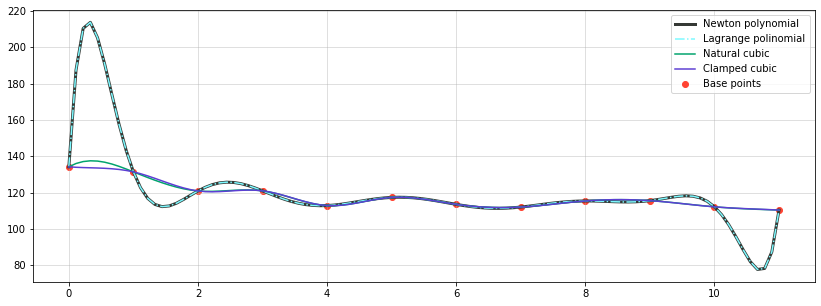

In [42]:
fig = plt.figure(figsize = [14, 5])

ax = fig.add_subplot(1,1,1)

ax.scatter(x, S, label = 'Base points', color = '#FF4433')
ax.plot(X_est, Y_est_Newton, label = 'Newton polynomial', color = '#353935', lw = 3)
ax.plot(X_est, Y_est_Lr, label = 'Lagrange polinomial', linestyle = '-.', color = '#7DF9FF')
ax.plot(X_est, Y_est_ncs, label = 'Natural cubic', color = '#00A36C')
ax.plot(X_est, Y_est_cc, label = 'Clamped cubic', color = '#5D3FD3')

#x.scatter(8.5, float(y), color = 'cyan', marker = '*', s = 100)

ax.grid(True, alpha = 0.5)
ax.legend()

plt.show()

For each method state the interpolated price for the Apple stock for day $x = 8.5$

In [43]:
day85 = np.array([8.5])

price_day85_ncs = piecewise_cubic(day85, x, coef_natspline)
price_day85_cc = piecewise_cubic(day85, x, coef_clamped)
price_day85_Newton = poly_Newton(x, day85, coef_Newton)
price_day85_Lr = poly_Lagrange(x, S, day85)

price_day85_df = pd.DataFrame({'Natural Cubic': price_day85_ncs,
                               'Clamped Cubic': price_day85_cc,
                               'Newton Poly': price_day85_Newton,
                               'Lagrange Poly': price_day85_Lr})
price_day85_df

,Natural Cubic,Clamped Cubic,Newton Poly,Lagrange Poly
0,116.088038,116.094923,114.877922,114.877922


## Question 9

Let $f(x) = e^{\frac{x^2}{10}}$

In [44]:
def f_9(X):
    return np.exp((X**2)/10)

def df_9(X):
    return 1/5*X*np.exp((X**2)/10)

### (i) Compute coefficients of the interpolating polynomial

#### Cubic Hermite polynomial

Base points $X_0 = 1, X_1 = 1.5$

In [45]:
X_base = np.array([1, 1.5])

M_Hermite3 = np.array([])

for i in range(X_base.shape[0]):
    Mi = [1, X_base[i], X_base[i]**2, X_base[i]**3]
    M_Hermite3 = np.append(M_Hermite3, Mi).reshape(-1, 4)
for i in range(X_base.shape[0]):
    Mi = [0, 1, 2*X_base[i], 3*(X_base[i]**2)]
    M_Hermite3 = np.append(M_Hermite3, Mi).reshape(-1, 4)
M_Hermite3

array([[1.   , 1.   , 1.   , 1.   ],
       [1.   , 1.5  , 2.25 , 3.375],
       [0.   , 1.   , 2.   , 3.   ],
       [0.   , 1.   , 3.   , 6.75 ]])

In [46]:
V_Hermite3 = np.array([f_9(X_base), df_9(X_base)]).reshape(4,)
V_Hermite3

array([1.10517092, 1.25232272, 0.22103418, 0.37569681])

In [47]:
A_Hermite3 = np.dot(np.linalg.inv(M_Hermite3), V_Hermite3)

In [48]:
print("Cubic Hermite polynomial:")
print()
print(f"P(X) = {A_Hermite3[0]:.2f} + {A_Hermite3[1]:.2f}X + {A_Hermite3[2]:.2f}X^2 + {A_Hermite3[3]:.2f}X^3")

Cubic Hermite polynomial:

P(X) = 0.98 + 0.06X + 0.03X^2 + 0.03X^3


#### Hermite interpolating polynomial of degree 5

Base points $X = [1, 2, 3]$

In [49]:
X_base = np.array([1, 2, 3])

M_Hermite5 = np.array([])

#(1) P(X) = f(X)
for i in range(X_base.shape[0]):
    Xi = X_base[i]
    Mi = [1, Xi, Xi**2, Xi**3, Xi**4, Xi**5]
    M_Hermite5 = np.append(M_Hermite5, Mi).reshape(-1, 6)

#(2) P'(X) = f'(X)
for i in range(X_base.shape[0]):
    Xi = X_base[i]
    Mi = [0, 1, 2*Xi, 3*(Xi**2), 4*(Xi**3), 5*(Xi**4)]
    M_Hermite5 = np.append(M_Hermite5, Mi).reshape(-1, 6)
M_Hermite5

array([[  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.,  32.],
       [  1.,   3.,   9.,  27.,  81., 243.],
       [  0.,   1.,   2.,   3.,   4.,   5.],
       [  0.,   1.,   4.,  12.,  32.,  80.],
       [  0.,   1.,   6.,  27., 108., 405.]])

In [50]:
V_Hermite5 = np.array([f_9(X_base), df_9(X_base)]).reshape(X_base.shape[0]*2,)
V_Hermite5

array([1.10517092, 1.4918247 , 2.45960311, 0.22103418, 0.59672988,
       1.47576187])

In [51]:
A_Hermite5 = np.dot(np.linalg.inv(M_Hermite5), V_Hermite5)
print("Hermite interpolating polynomial of degree 5:")
print()
print(f"P(X) = {A_Hermite5[0]:.2f} + {A_Hermite5[1]:.2f}X + {A_Hermite5[2]:.2f}X^2 + {A_Hermite5[3]:.2f}X^3 + {A_Hermite5[4]:.2f}X^4, {A_Hermite5[5]:.2f}X^5")

Hermite interpolating polynomial of degree 5:

P(X) = 0.97 + 0.10X + -0.04X^2 + 0.09X^3 + -0.03X^4, 0.01X^5


### (ii) Approximate $f(1.2)$

Approximate by cubic Hermite polynomial

In [52]:
#Y_Hermite3 = P(1.2)
Y_Hermite3 = np.dot(np.array([1, 1.2, 1.2**2, 1.2**3]), A_Hermite3)
Y_Hermite3

1.1548493651196758

In [53]:
#Actual value of f(1.2)
f_9(1.2)

1.1548841085249135

Approximate by Hermite interpolating polynomial of degree 5

In [54]:
#Y_Hermite5 = P(1.2)
Y_Hermite5 = np.dot(np.array([1, 1.2, 1.2**2, 1.2**3, 1.2**4, 1.2**5]), A_Hermite5)
Y_Hermite5

1.1548058841283004

### (iii) Find an upper bound in the absolute value  of error

Using the formula 

$\large | \varepsilon(X) | \le \frac{M^{n+1}}{n+1}max_{X_0 \le X \le X_n}|\Pi^{n}_{i = 0}(X-X_i)|$

obtain the upper bounds as follows:
- For Cubic Hermite interpolating polynomial: $| \varepsilon(X) | \le 1.5625*10^{-3} $
- For Hermite interpolating polynomial of degree 5: $| \varepsilon(X) | \le 7.5756*10^{-3} $

In [55]:
E_Hermite3 = 1.5625*(10**-3)
E_Hermite5 = 7.5756*(10**-3)

#### (iv) Plot the actual error and the error bound from (iii)

In [56]:
N = 1000

In [57]:
X_Hermite3_est = np.linspace(1,1.5,N)

X_Hermite3_matrix = np.array([])
for i in range(N):
    Xi = X_Hermite3_est[i]
    X_Hermite3_matrix = np.append(X_Hermite3_matrix, [1, Xi, Xi**2, Xi**3]).reshape(-1, 4)

Y_Hermite3_est = np.dot(X_Hermite3_matrix, A_Hermite3)
Y_Hermite3_est.shape

(1000,)

In [58]:
X_Hermite5_est = np.linspace(1,3,N)

X_Hermite5_matrix = np.array([])
for i in range(N):
    Xi = X_Hermite5_est[i]
    X_Hermite5_matrix = np.append(X_Hermite5_matrix, [1, Xi, Xi**2, Xi**3, Xi**4, Xi**5]).reshape(-1, 6)

Y_Hermite5_est = np.dot(X_Hermite5_matrix, A_Hermite5)
Y_Hermite5_est.shape

(1000,)

In [59]:
E_Hermite3_actual = Y_Hermite3_est - f_9(X_Hermite3_est)
E_Hermite5_actual = Y_Hermite5_est - f_9(X_Hermite5_est)

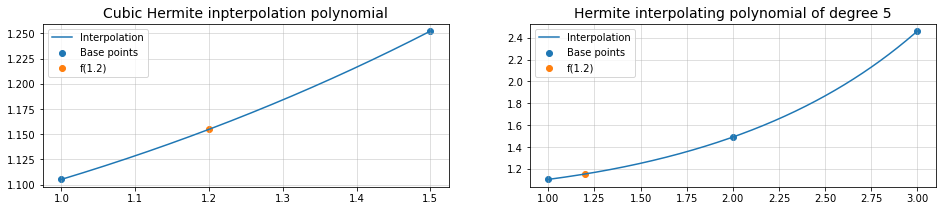

In [60]:
fig = plt.figure(figsize = (16, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('Cubic Hermite inpterpolation polynomial', size = 14)
ax1.plot(X_Hermite3_est, Y_Hermite3_est, label = 'Interpolation')
ax1.scatter([1, 1.5], [f_9(1), f_9(1.5)], label = 'Base points')
ax1.scatter(1.2, f_9(1.2), label = 'f(1.2)')
ax1.grid(True, alpha = 0.5)
ax1.legend()

ax2.set_title('Hermite interpolating polynomial of degree 5', size = 14)
ax2.plot(X_Hermite5_est, Y_Hermite5_est, label = 'Interpolation')
ax2.scatter([1, 2, 3], [f_9(1), f_9(2), f_9(3)], label = 'Base points')
ax2.scatter(1.2, f_9(1.2), label = 'f(1.2)')
ax2.grid(True, alpha = 0.5)
ax2.legend()

plt.show()

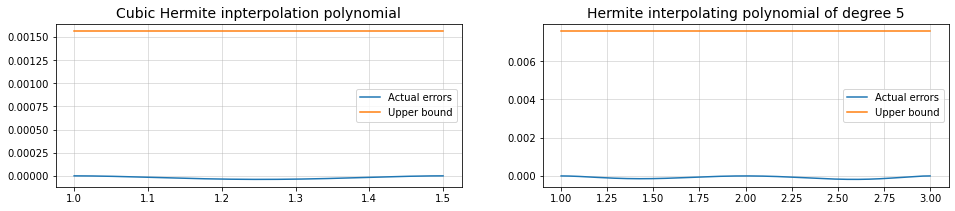

In [61]:
fig = plt.figure(figsize = (16, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('Cubic Hermite inpterpolation polynomial', size = 14)
ax1.plot(X_Hermite3_est, E_Hermite3_actual, label = 'Actual errors')
ax1.plot(X_Hermite3_est, np.full((N,), E_Hermite3), label = 'Upper bound')
ax1.grid(True, alpha = 0.5)
ax1.legend()

ax2.set_title('Hermite interpolating polynomial of degree 5', size = 14)
ax2.plot(X_Hermite5_est, E_Hermite5_actual, label = 'Actual errors')
ax2.plot(X_Hermite5_est, np.full((N,), E_Hermite5), label = 'Upper bound')
ax2.grid(True, alpha = 0.5)
ax2.legend()

plt.show()